# import

In [1]:
import pandas as pd
from source import cls
from source import auto
import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
import pickle
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import traceback

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [2]:
user = pd.read_csv('dataset/user.csv')
book = pd.read_csv('dataset/book.csv')
print(len(user['ID'].unique()), len(book['Name']))

3822 30470


In [3]:
book['Cluster'].unique()

array([4, 3, 2, 0, 1], dtype=int64)

# Облака слов кластеров

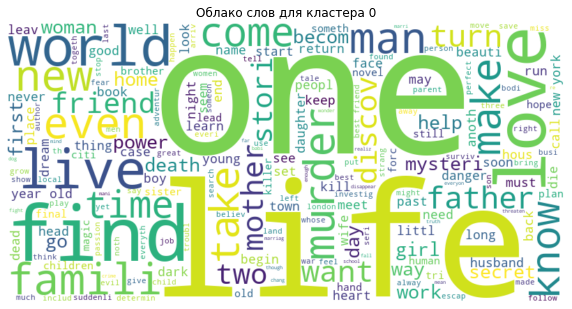

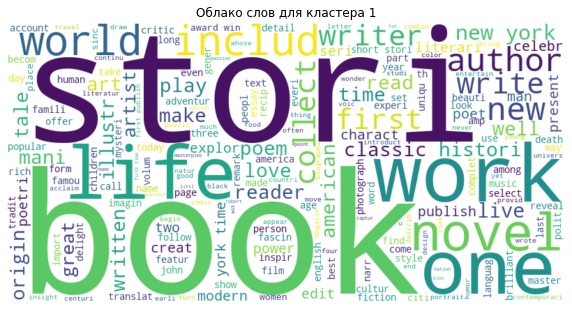

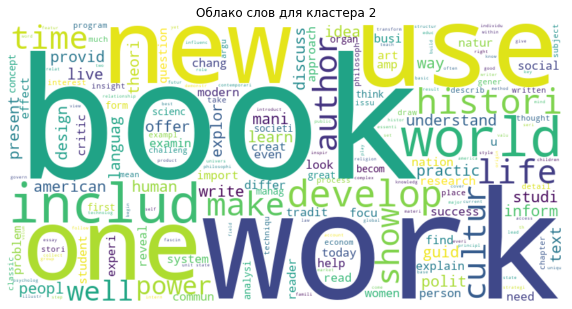

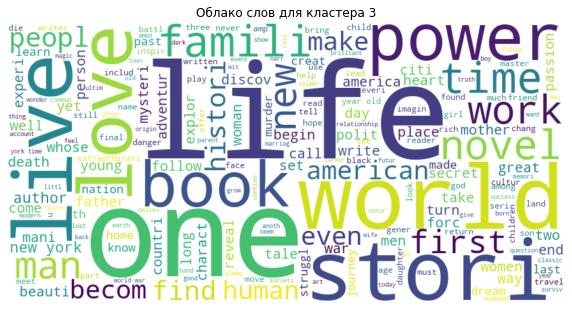

In [4]:
grouped_text = book.groupby('Cluster')['Stem_Description'].apply(lambda x: ' '.join(x)).reset_index()

# Создаем объект WordCloud для каждого кластера
for index, row in grouped_text.iterrows():
    cluster = row['Cluster']
    text = row['Stem_Description']
    
    # Генерируем облако слов для текста в текущем кластере
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Отображаем облако слов
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов для кластера {cluster}')
    plt.axis('off')
    plt.show()

## Частота слов в кластерах

In [5]:
# Создаем словарь для хранения наиболее часто встречающихся слов в каждом кластере
cluster_word_freq = {}

# Проходим по каждой строке DataFrame
for index, row in grouped_text.iterrows():
    cluster = row['Cluster']
    text = row['Stem_Description']
    
    # Токенизируем текст
    tokens = word_tokenize(text)
    
    # Создаем объект FreqDist для подсчета частоты слов
    fdist = FreqDist(tokens)
    
    # Получаем наиболее часто встречающиеся слова и их частоту
    top_words = fdist.most_common(20)  # Здесь выбираем 5 наиболее часто встречающихся слов
    
    # Сохраняем результаты в словарь cluster_word_freq
    cluster_word_freq[cluster] = top_words

# Выводим наиболее часто встречающиеся слова для каждого кластера
for cluster, top_words in cluster_word_freq.items():
    print(f"Кластер {cluster}:")
    for word, freq in top_words:
        print(f"Слово: {word}, Частота: {freq}")
    print()

Кластер 0:
Слово: one, Частота: 3045
Слово: life, Частота: 3040
Слово: love, Частота: 2591
Слово: new, Частота: 2301
Слово: find, Частота: 1956
Слово: time, Частота: 1794
Слово: live, Частота: 1757
Слово: famili, Частота: 1757
Слово: stori, Частота: 1741
Слово: make, Частота: 1735
Слово: get, Частота: 1696
Слово: book, Частота: 1632
Слово: friend, Частота: 1595
Слово: like, Частота: 1574
Слово: world, Частота: 1484
Слово: year, Частота: 1437
Слово: come, Частота: 1386
Слово: know, Частота: 1373
Слово: way, Частота: 1363
Слово: take, Частота: 1325

Кластер 1:
Слово: book, Частота: 4085
Слово: new, Частота: 2615
Слово: work, Частота: 2479
Слово: world, Частота: 1815
Слово: use, Частота: 1645
Слово: includ, Частота: 1521
Слово: cultur, Частота: 1507
Слово: one, Частота: 1447
Слово: histori, Частота: 1439
Слово: polit, Частота: 1330
Слово: provid, Частота: 1309
Слово: develop, Частота: 1234
Слово: make, Частота: 1213
Слово: time, Частота: 1201
Слово: author, Частота: 1174
Слово: way, Часто

In [6]:
user

,ID,Name,Rating,Rating_score,Rating_bin
0,1,The Restaurant at the End of the Universe (Hit...,it was amazing,5,1
1,73,The Restaurant at the End of the Universe (Hit...,really liked it,4,1
2,116,The Restaurant at the End of the Universe (Hit...,it was amazing,5,1
3,171,The Restaurant at the End of the Universe (Hit...,really liked it,4,1
4,338,The Restaurant at the End of the Universe (Hit...,liked it,3,0
...,...,...,...,...,...
173873,10978,Smile As They Bow,liked it,3,0
173874,10978,Speak Rwanda,really liked it,4,1
173875,10978,India After Gandhi: The History of the World's...,really liked it,4,1
173876,10988,Facing the Lion: Growing Up Maasai on the Afri...,liked it,3,0


# Рекомендации и классификаторы

In [4]:
user = user.merge(book, on='Name').drop(['Description', 'Stem_Description'], axis=1)
df_train, df_test = train_test_split(user, test_size=0.3, random_state=12345)
        # df_train = df_train.join(book.set_index('Name'), on='Name', how='inner').drop(['Rating', 'Description'], axis=1)
        # df_test = df_test.join(book.set_index('Name'), on='Name', how='inner').drop(['Rating', 'Description'], axis=1)

# df_train = df_train.merge(book, on='Name').drop(['Description', 'Stem_Description'], axis=1)
# df_test = df_test.merge(book, on='Name').drop(['Description', 'Stem_Description'], axis=1)

`Краткое описание`: вычиляем, какие кластеры пользователь читал чаще всего. Если в `15%` или больше прочитанного, обучаем на нем классификатор и предсказываем оценки 0 или 1

### Нейросетевой классификатор

In [ ]:
# Определение архитектуры нейронной сети
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [31]:
# Функция с нейронкой подбора рекомендаций и классификации 

with open('source/Word2Vec_array_29.03.2024.pk1', 'rb') as f:
    documents_dict = pickle.load(f)

def reco_classifier(id: int, threshold: float=15.0):
    """Алгоритм: считаем в каких кластерах было больше всего понравившихся книг, обучаем классификаторы к тех кластерах, где больше 15% понравившихся от общего числа понравившихся"""
    # сначала расчет понравившихся кластеров
    like_df = df_train[(df_train['ID'] == id) & (df_train['Rating_bin'] == 1)]
    like_df = like_df.merge(book, on='Name')

    cluster_dict = like_df['Cluster'].value_counts().to_dict()

    cluster = cluster_dict.keys()
    percent = np.round(np.array(list(cluster_dict.values())) / sum(cluster_dict.values()) * 100)

    percent_cluster = dict(zip(percent, cluster))

    df = df_train[(df_train['ID'] == id)]   # Подготовка датафрейма с текущим id
    df = df.merge(book, on='Name')

    df_exam = df_test[(df_test['ID'] == id)]
    df_exam = df_exam.merge(book, on='Name')

    accuracy = []

    for key in list(percent_cluster.keys()):
        if key >= threshold:
            temp_df = df[df['Cluster'] == percent_cluster[key]]
            X_train = np.array([documents_dict.get(name) for name in list(temp_df['Name'])])
            y_train = np.array(temp_df['Rating_bin'])
            temp_df_exam = df_exam[df_exam['Cluster'] == percent_cluster[key]]
            X_test = np.array([documents_dict.get(key) for key in list(temp_df_exam['Name'])])
            y_test = np.array(temp_df_exam['Rating_bin'])


            # Преобразование данных в тензоры PyTorch
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.long)
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)
            # Инициализация модели и параметров обучения
            input_size = (X_train).shape[1]
            hidden_size = 64
            num_classes = len(np.unique(y_train))
            model = SimpleNN(input_size, hidden_size, num_classes)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Обучение модели
            num_epochs = 500
            for epoch in range(num_epochs):
                # Forward pass
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # if (epoch+1) % 100 == 0:
                #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            # Оценка модели на тестовом наборе
            with torch.no_grad():
                outputs = model(X_test_tensor)
                _, predicted = torch.max(outputs.data, 1)
                accuracy_sc = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
                # print("Accuracy:", accuracy)
                
            
                accuracy.append(accuracy_sc)

    return accuracy

### Классические алгоритмы МО

In [5]:
import warnings
warnings.filterwarnings("ignore")

with open('source/Word2Vec_array_29.03.2024.pk1', 'rb') as f:
    documents_dict = pickle.load(f)

global accuracy_df
accuracy_df = pd.DataFrame(columns=user.columns)

In [6]:
# Функция для подбора рекомендаций и классификации 

def reco_classifier(id: int, threshold: float=15.0, log_file=None):
    """Алгоритм: считаем в каких кластерах было больше всего понравившихся книг, обучаем классификаторы к тех кластерах, где больше 15% понравившихся от общего числа понравившихся"""
    global accuracy_df
    # сначала расчет понравившихся кластеров
    like_df = df_train[(df_train['ID'] == id) & (df_train['Rating_bin'] == 1)]
    # like_df = like_df.merge(book, on='Name')

    cluster_dict = like_df['Cluster'].value_counts().to_dict()  # Подстчет процентов по кластерам
    cluster = cluster_dict.keys()
    percent = np.round(np.array(list(cluster_dict.values())) / sum(cluster_dict.values()) * 100)
    percent_cluster = dict(zip(percent, cluster))   # Инвертировано, проценты - ключи, значения - кластеры

    accuracy = []; predict = []

    for key in list(percent_cluster.keys()):
        if key >= threshold:
            temp_df = df_train[(df_train['ID'] == id) & (df_train['Cluster'] == percent_cluster[key])]
            X_train = np.array([documents_dict.get(name) for name in list(temp_df['Name'])])
            y_train = np.array(temp_df['Rating_bin'])
            temp_df_exam = df_test[(df_test['ID'] == id) & (df_test['Cluster'] == percent_cluster[key])]
            X_test = np.array([documents_dict.get(key) for key in list(temp_df_exam['Name'])])
            y_test = np.array(temp_df_exam['Rating_bin'])

            model = KNeighborsClassifier(n_neighbors=1)

            param_grid = {'n_neighbors': [2, 3, 5, 10], 'algorithm': ['auto'], 'metric': ['minkowski', 'euclidean', 'cosine']}

            # Создание объекта GridSearchCV для автоматического подбора параметров
            try:
                grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

                grid_search.fit(X_train, y_train)
                # print("Наилучшие параметры:", grid_search.best_params_)

                try:
                    accuracy.append(grid_search.score(X_test, y_test))
                    # Предсказание на тестовом наборе 
                    y_pred = grid_search.predict(X_test)
                except:
                    log_file.write('Ошибка 1 с юзером ' + str(id) + ' и кластером ' + str(percent_cluster[key]) + " нет тестового набора данных\n")
                    # print('Ошибка 1 с юзером', id, 'и кластером', percent_cluster[key], "нет тестового набора данных")

                temp_df_exam['Predict_bin'] = y_pred
                accuracy_df = pd.concat([accuracy_df, temp_df_exam])

                # accuracy.append(accuracy_score(y_test, y_pred))

            except Exception as e:
                log_file.write('Ошибка 2 с юзером ' + str(id) + ' и кластером ' + str(percent_cluster[key]) + " недостаточно тренировочных данных\n")
                # print('Ошибка 2 с юзером', id, 'и кластером', percent_cluster[key], "недостаточно тренировочных данных")
                # print('Ошибка:\n', traceback.format_exc())

    return accuracy

In [7]:
global accuracy_df
accuracy_df = pd.DataFrame(columns=user.columns)

accuracy = []

with open('output/log_reco_error.txt', 'w') as f:
    for i in tqdm(user['ID'].unique()):
        # print(i)
        accuracy.append(reco_classifier(i, log_file=f))

100%|██████████| 3822/3822 [04:23<00:00, 14.53it/s] 


In [8]:
accuracy_df_score = accuracy_df[~accuracy_df['Rating_bin'].isna()]

In [9]:
cls_report = classification_report(np.array(accuracy_df_score['Rating_bin'], dtype=int), np.array(accuracy_df_score['Predict_bin'], dtype=int))
print(cls_report)

              precision    recall  f1-score   support

           0       0.47      0.51      0.49     13306
           1       0.72      0.69      0.70     24219

    accuracy                           0.62     37525
   macro avg       0.59      0.60      0.60     37525
weighted avg       0.63      0.62      0.63     37525



In [10]:
accuracy_df.to_csv(f'output/accuracy_df {len(book.Cluster.unique())} cluster.docx.csv')

In [11]:
auto.autoTable(cls_report, f'output/classificationReport {len(book.Cluster.unique())} cluster.docx')

In [73]:
accuracy

[[0.7586206896551724, 0.8, 0.75],
 [0.42857142857142855, 0.6666666666666666, 0.4],
 [1.0, 1.0],
 [1.0, 1.0, 1.0],
 [0.5492957746478874, 0.7, 0.75],
 [0.8, 0.5, 0.625],
 [0.5714285714285714, 0.6666666666666666, 0.625],
 [0.5, 0.7727272727272727, 0.5714285714285714],
 [0.5],
 [0.4166666666666667, 0.14285714285714285],
 [0.8421052631578947, 0.88],
 [0.45, 0.6666666666666666],
 [0.0, 0.4, 0.46153846153846156],
 [0.7857142857142857, 0.4, 0.7333333333333333],
 [0.5957446808510638, 0.6153846153846154, 0.6956521739130435],
 [0.5, 0.6, 0.0],
 [0.4666666666666667, 0.6190476190476191, 0.5],
 [0.6666666666666666, 0.3333333333333333, 0.5, 0.5],
 [0.5, 0.5, 0.5882352941176471],
 [0.9047619047619048,
  0.6363636363636364,
  0.4444444444444444,
  0.8333333333333334],
 [0.8888888888888888, 0.7, 0.5, 0.6923076923076923],
 [0.5277777777777778,
  0.5555555555555556,
  0.6666666666666666,
  0.5714285714285714],
 [0.88, 0.7407407407407407],
 [0.7048192771084337, 0.8295454545454546, 0.6595744680851063],
 [0.